In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Flatten, Dense, Reshape, Conv2DTranspose, Conv2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import backend as K

import data_utils
%matplotlib inline 

conf = tf.ConfigProto()
conf.gpu_options.allow_growth = True
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [2]:
from skimage.measure import compare_ssim
def get_mse(image1, image2):
    image1 = tf.reshape(image1, [-1, 64, 64, 3])
    image2 = tf.reshape(image2, [-1, 64, 64, 3])
    return tf.reduce_mean(tf.square(image1-image2))

def get_mae(image1, image2):
    image1 = (image1*255).astype(int).reshape(-1, 64, 64, 3)
    image2 = (image2*255).astype(int).reshape(-1, 64, 64, 3)
    return np.mean(np.abs(image1-image2))

def get_ssim(image1, image2):
    image1 = (image1*255).astype(int).reshape(-1, 64, 64, 3)
    image2 = (image2*255).astype(int).reshape(-1, 64, 64, 3)
    ssim_values = np.zeros(image1.shape[0])
    for i in range(image1.shape[0]):
        tp_im1 = image1[i].reshape(64, 64 ,3)
        tp_im2 = image2[i].reshape(64, 64 ,3)
        ssim_values[i] = compare_ssim(tp_im1, tp_im2, data_range=255, multichannel=True)
    return np.mean(ssim_values)

In [6]:
batch_size = 3000
x_train_in, x_train_out = data_utils.get_train_batch(batch_size)
x_train = np.concatenate((x_train_in,x_train_out),axis=1).reshape(-1,64,64,3)
x_val = np.concatenate(data_utils.get_val_batch(0,100), axis=1).reshape(-1, 64, 64, 3)

In [3]:
def conv_transpose(filters, kernel_size, strides):
    return Conv2DTranspose(filters, kernel_size, strides, activation=tf.nn.relu, padding='same', 
                            kernel_initializer=tf.contrib.layers.xavier_initializer(),
                            kernel_regularizer=tf.contrib.layers.l2_regularizer(1e-6))
def conv(filters, kernel_size, strides):
    return Conv2D(filters, kernel_size, strides, activation=tf.nn.relu, padding='same',
                   kernel_initializer=tf.contrib.layers.xavier_initializer(),
                   kernel_regularizer=tf.contrib.layers.l2_regularizer(1e-6))

In [4]:
# input [None, 64, 64, 3]
encoder = Sequential()
encoder.add(Flatten(input_shape=(64, 64, 3)))
encoder.add(Dense(1024, activation = 'tanh'))

# input [None, 1024]
decoder = Sequential()
decoder.add(Reshape((8, 8, 16), input_shape=(1024,)))
decoder.add(conv_transpose(16, 3, 2))
decoder.add(conv(16, 3, 1))
decoder.add(conv_transpose(16, 3, 2))
decoder.add(conv(16, 3, 1))
decoder.add(conv_transpose(8, 3, 2))
decoder.add(conv(3, 3, 1))

autoencoder = Sequential()
autoencoder.add(encoder)
autoencoder.add(decoder)

autoencoder.compile(optimizer=Adam(lr=0.0005), loss='mean_squared_error')
autoencoder.summary()

Instructions for updating:
Colocations handled automatically by placer.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 1024)              12583936  
_________________________________________________________________
sequential_1 (Sequential)    (None, 64, 64, 3)         10659     
Total params: 12,594,595
Trainable params: 12,594,595
Non-trainable params: 0
_________________________________________________________________


In [5]:
checkpoint_dir = 'checkpoint/autoencoder2' 
checkpoint_file = 'autoencoder2.h5'
checkpoint_path = os.path.join(checkpoint_dir, checkpoint_file)
if not os.path.isdir(checkpoint_dir):
    os.makedirs(checkpoint_dir)
# Load previous weights 
if os.path.isfile(checkpoint_path):
    autoencoder.load_weights(checkpoint_path)
    print('Restored previous autoencoder model')
def step_decay_schedule(initial_lr=1e-4, decay_factor=0.75, step_size=10):
    def schedule(epoch):
        return initial_lr * (decay_factor ** np.floor(epoch/step_size))
    return LearningRateScheduler(schedule)
# prepare callbacks
callbacks = [
    ModelCheckpoint(checkpoint_path,
        monitor='val_loss', 
        save_best_only=True, 
        verbose=1),
    step_decay_schedule(),
    ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6),
    EarlyStopping(monitor='val_loss', patience=100)
]

Restored previous autoencoder model


In [130]:
autoencoder.fit(x_train, x_train, batch_size=100, epochs=20, callbacks=callbacks, 
                validation_data=(x_val, x_val))#, validation_steps=2)


Train on 60000 samples, validate on 2000 samples
Epoch 1/20
59900/60000 [============================>.] - ETA: 0s - loss: 2.7212e-04
Epoch 00001: val_loss improved from inf to 0.00028, saving model to checkpoint/autoencoder2/autoencoder2.h5
60000/60000 [==============================] - 32s 527us/sample - loss: 2.7211e-04 - val_loss: 2.7627e-04
Epoch 2/20
59900/60000 [============================>.] - ETA: 0s - loss: 2.6069e-04
Epoch 00002: val_loss improved from 0.00028 to 0.00027, saving model to checkpoint/autoencoder2/autoencoder2.h5
60000/60000 [==============================] - 31s 524us/sample - loss: 2.6069e-04 - val_loss: 2.7407e-04
Epoch 3/20
59800/60000 [============================>.] - ETA: 0s - loss: 2.5541e-04
Epoch 00003: val_loss improved from 0.00027 to 0.00027, saving model to checkpoint/autoencoder2/autoencoder2.h5
60000/60000 [==============================] - 31s 522us/sample - loss: 2.5537e-04 - val_loss: 2.7209e-04
Epoch 4/20
59900/60000 [======================

In [7]:
pred_val = autoencoder.predict(x_val)
mae_ = get_mae(pred_val, x_val)
ssim_ = get_ssim(pred_val, x_val)
print('mae: %.5f ssim: %.5f' % (mae_, ssim_))

mae: 0.53019 ssim: 0.99410


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


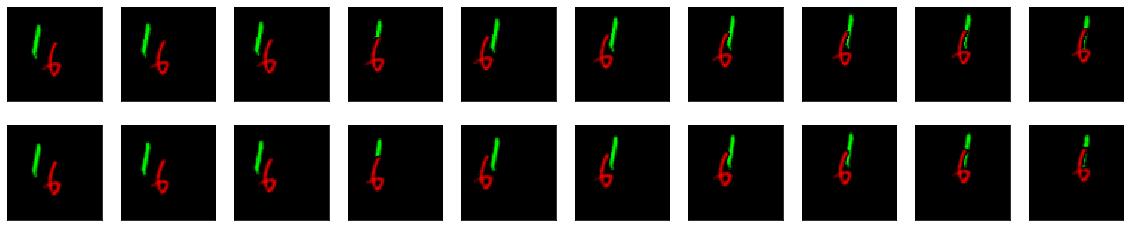

In [8]:
decoded_imgs = autoencoder.predict(x_val)
import matplotlib.pyplot as plt
%matplotlib inline 
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # 원본 출력
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_val[i].reshape(64, 64, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # 재구성본 출력
    ax = plt.subplot(2, n, i + n+1)
    plt.imshow(decoded_imgs[i].reshape(64, 64, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [9]:
#LSTM set up 
from tensorflow.keras.layers import LSTM, BatchNormalization , Lambda, TimeDistributed

LSTM_model = Sequential()
LSTM_model.add(LSTM(input_shape=(20, 1024), units=512, return_sequences=True, activation = 'relu', dropout = 0.3))
LSTM_model.add(BatchNormalization(momentum = 0.9))
#LSTM_model.add(TimeDistributed(Dense(1024)))
#decoder.add(conv(16, 3, 1))
#LSTM_model.add(BatchNormalization(momentum = 0.9))

LSTM_model.add(LSTM(units= 2048, return_sequences=True, activation = 'relu', dropout = 0.3))
#LSTM_model.add(Lambda(lambda x: x[:, -10:, :]))
LSTM_model.add(BatchNormalization(momentum =0.9))

#LSTM_model.add(LSTM( units= 1024, return_sequences=True, activation = 'relu', dropout = 0.3))
#LSTM_model.add(Lambda(lambda x: x[:, -10:, :]))
#LSTM_model.add(BatchNormalization(momentum =0.9))
#LSTM_model.add(LSTM(units= 1024, return_sequences=True, activation = 'tanh', dropout = 0.3))
LSTM_model.add(TimeDistributed(Dense(1024, activation = 'tanh')))

LSTM_model.compile(optimizer='rmsprop', loss='mean_squared_error')
#LSTM_model.compile(optimizer= Adam(lr=0.0003), loss='mean_squared_error')
LSTM_model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20, 512)           3147776   
_________________________________________________________________
batch_normalization_v1 (Batc (None, 20, 512)           2048      
_________________________________________________________________
lstm_1 (LSTM)                (None, 20, 2048)          20979712  
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 20, 2048)          8192      
_________________________________________________________________
time_distributed (TimeDistri (None, 20, 1024)          2098176   
Total params: 26,235,904
Trainable params: 26,230,784
Non-trainable params: 5,120
_________________________________________________________________


In [10]:
x_val_in, x_val_out = data_utils.get_val_batch(0, 500) 

x_val_in = x_val_in.reshape(-1,64,64,3)
encoded_val_imgs_in = encoder.predict(x_val_in).reshape(-1,10,1024)
encoded_val_imgs_out = encoder.predict(x_val_out.reshape(-1,64,64,3)).reshape(-1,10,1024)
zero_val_vec = np.zeros_like(encoded_val_imgs_in)
concate_val_in = np.concatenate((encoded_val_imgs_in, zero_val_vec), axis=1)
concate_val_out = np.concatenate((encoded_val_imgs_in, encoded_val_imgs_out), axis=1)

In [30]:
checkpoint_dir = 'checkpoint/lstm_tanh_am' 
checkpoint_file = 'lstm_tanh_am.h5'
checkpoint_path = os.path.join(checkpoint_dir, checkpoint_file)
if not os.path.isdir(checkpoint_dir):
    os.makedirs(checkpoint_dir)
# Load previous weights 
if os.path.isfile(checkpoint_path):
    LSTM_model.load_weights(checkpoint_path)
    print('Restored previous lstm model')
def step_decay_schedule(initial_lr= 0.0002, decay_factor=0.5, step_size=60):
    def schedule(epoch):
        return initial_lr * (decay_factor ** np.floor(epoch/step_size))
    return LearningRateScheduler(schedule, verbose=1)
# prepare callbacks
callbacks = [
    ModelCheckpoint(checkpoint_path,
        monitor='val_loss', 
        save_best_only=True, 
        verbose=1),
    step_decay_schedule(),
    ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6),
    EarlyStopping(monitor='val_loss', patience=100)
]

Restored previous lstm model


In [33]:
for e in range(3):
    print("EPOCH : ", e)
    print("--------------------shuffle train data---------------------")
    x_train_in, x_train_out = data_utils.get_train_batch(5000)
    x_train_in = x_train_in.reshape([-1,64,64,3])
    encoded_train_imgs_in = encoder.predict(x_train_in).reshape(-1,10,1024)
    encoded_train_imgs_out = encoder.predict(x_train_out.reshape(-1,64,64,3)).reshape(-1,10,1024)
    concate_train_out = np.concatenate((encoded_train_imgs_in, encoded_train_imgs_out), axis=1)
    zero_train_vec = np.zeros_like(encoded_train_imgs_in)
    concate_train_in = np.concatenate((encoded_train_imgs_in, zero_train_vec), axis=1)
    #LSTM_model.load_weights("LSTM_6_26_model.h5")
    LSTM_model.fit(concate_train_in, concate_train_out,
               epochs=120,
               batch_size=100,
               shuffle=True,
               callbacks=callbacks,
               validation_data=(concate_val_in, concate_val_out))
    LSTM_model.save_weights("LSTM_new_model.h5")
    print("model saved")

EPOCH :  0
--------------------shuffle train data---------------------
Train on 5000 samples, validate on 500 samples

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0002.
Epoch 1/120
4900/5000 [============================>.] - ETA: 0s - loss: 0.0417
Epoch 00001: val_loss improved from inf to 0.04067, saving model to checkpoint/lstm_tanh_am/lstm_tanh_am.h5
5000/5000 [==============================] - 28s 6ms/sample - loss: 0.0417 - val_loss: 0.0407

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0002.
Epoch 2/120
4900/5000 [============================>.] - ETA: 0s - loss: 0.0416
Epoch 00002: val_loss improved from 0.04067 to 0.04064, saving model to checkpoint/lstm_tanh_am/lstm_tanh_am.h5
5000/5000 [==============================] - 28s 6ms/sample - loss: 0.0416 - val_loss: 0.0406

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0002.
Epoch 3/120
4900/5000 [============================>.] - ETA: 0s - loss: 0.0415
Epoch 00003: val_loss di


Epoch 00027: LearningRateScheduler reducing learning rate to 0.0002.
Epoch 27/120
4900/5000 [============================>.] - ETA: 0s - loss: 0.0407
Epoch 00027: val_loss did not improve from 0.04045
5000/5000 [==============================] - 28s 6ms/sample - loss: 0.0406 - val_loss: 0.0405

Epoch 00028: LearningRateScheduler reducing learning rate to 0.0002.
Epoch 28/120
4900/5000 [============================>.] - ETA: 0s - loss: 0.0406
Epoch 00028: val_loss did not improve from 0.04045
5000/5000 [==============================] - 28s 6ms/sample - loss: 0.0406 - val_loss: 0.0406

Epoch 00029: LearningRateScheduler reducing learning rate to 0.0002.
Epoch 29/120
4900/5000 [============================>.] - ETA: 0s - loss: 0.0406
Epoch 00029: val_loss did not improve from 0.04045
5000/5000 [==============================] - 28s 6ms/sample - loss: 0.0406 - val_loss: 0.0406

Epoch 00030: LearningRateScheduler reducing learning rate to 0.0002.
Epoch 30/120
4900/5000 [==================


Epoch 00054: LearningRateScheduler reducing learning rate to 0.0002.
Epoch 54/120
4900/5000 [============================>.] - ETA: 0s - loss: 0.0401
Epoch 00054: val_loss did not improve from 0.04032
5000/5000 [==============================] - 28s 6ms/sample - loss: 0.0401 - val_loss: 0.0404

Epoch 00055: LearningRateScheduler reducing learning rate to 0.0002.
Epoch 55/120
4900/5000 [============================>.] - ETA: 0s - loss: 0.0401
Epoch 00055: val_loss did not improve from 0.04032
5000/5000 [==============================] - 28s 6ms/sample - loss: 0.0401 - val_loss: 0.0403

Epoch 00056: LearningRateScheduler reducing learning rate to 0.0002.
Epoch 56/120
4900/5000 [============================>.] - ETA: 0s - loss: 0.0401
Epoch 00056: val_loss did not improve from 0.04032
5000/5000 [==============================] - 28s 6ms/sample - loss: 0.0401 - val_loss: 0.0405

Epoch 00057: LearningRateScheduler reducing learning rate to 0.0002.
Epoch 57/120
4900/5000 [==================

4900/5000 [============================>.] - ETA: 0s - loss: 0.0395
Epoch 00080: val_loss did not improve from 0.04003
5000/5000 [==============================] - 28s 6ms/sample - loss: 0.0395 - val_loss: 0.0401

Epoch 00081: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 81/120
4900/5000 [============================>.] - ETA: 0s - loss: 0.0395
Epoch 00081: val_loss did not improve from 0.04003
5000/5000 [==============================] - 28s 6ms/sample - loss: 0.0395 - val_loss: 0.0401

Epoch 00082: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 82/120
4900/5000 [============================>.] - ETA: 0s - loss: 0.0395
Epoch 00082: val_loss did not improve from 0.04003
5000/5000 [==============================] - 28s 6ms/sample - loss: 0.0395 - val_loss: 0.0400

Epoch 00083: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 83/120
4900/5000 [============================>.] - ETA: 0s - loss: 0.0395
Epoch 00083: val_loss did not improve from 0

4900/5000 [============================>.] - ETA: 0s - loss: 0.0393
Epoch 00107: val_loss did not improve from 0.03997
5000/5000 [==============================] - 28s 6ms/sample - loss: 0.0393 - val_loss: 0.0400

Epoch 00108: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 108/120
4900/5000 [============================>.] - ETA: 0s - loss: 0.0393
Epoch 00108: val_loss did not improve from 0.03997
5000/5000 [==============================] - 28s 6ms/sample - loss: 0.0393 - val_loss: 0.0400

Epoch 00109: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 109/120
4900/5000 [============================>.] - ETA: 0s - loss: 0.0393
Epoch 00109: val_loss did not improve from 0.03997
5000/5000 [==============================] - 28s 6ms/sample - loss: 0.0393 - val_loss: 0.0400

Epoch 00110: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 110/120
4900/5000 [============================>.] - ETA: 0s - loss: 0.0393
Epoch 00110: val_loss did not improve fro


Epoch 00014: LearningRateScheduler reducing learning rate to 0.0002.
Epoch 14/120
4900/5000 [============================>.] - ETA: 0s - loss: 0.0400
Epoch 00014: val_loss did not improve from 0.03989
5000/5000 [==============================] - 28s 6ms/sample - loss: 0.0400 - val_loss: 0.0400

Epoch 00015: LearningRateScheduler reducing learning rate to 0.0002.
Epoch 15/120
4900/5000 [============================>.] - ETA: 0s - loss: 0.0400
Epoch 00015: val_loss did not improve from 0.03989
5000/5000 [==============================] - 28s 6ms/sample - loss: 0.0400 - val_loss: 0.0400

Epoch 00016: LearningRateScheduler reducing learning rate to 0.0002.
Epoch 16/120
4900/5000 [============================>.] - ETA: 0s - loss: 0.0399
Epoch 00016: val_loss did not improve from 0.03989
5000/5000 [==============================] - 28s 6ms/sample - loss: 0.0399 - val_loss: 0.0399

Epoch 00017: LearningRateScheduler reducing learning rate to 0.0002.
Epoch 17/120
4900/5000 [==================

4900/5000 [============================>.] - ETA: 0s - loss: 0.0394
Epoch 00041: val_loss improved from 0.03981 to 0.03979, saving model to checkpoint/lstm_tanh_am/lstm_tanh_am.h5
5000/5000 [==============================] - 28s 6ms/sample - loss: 0.0394 - val_loss: 0.0398

Epoch 00042: LearningRateScheduler reducing learning rate to 0.0002.
Epoch 42/120
4900/5000 [============================>.] - ETA: 0s - loss: 0.0394
Epoch 00042: val_loss improved from 0.03979 to 0.03973, saving model to checkpoint/lstm_tanh_am/lstm_tanh_am.h5
5000/5000 [==============================] - 28s 6ms/sample - loss: 0.0394 - val_loss: 0.0397

Epoch 00043: LearningRateScheduler reducing learning rate to 0.0002.
Epoch 43/120
4900/5000 [============================>.] - ETA: 0s - loss: 0.0394
Epoch 00043: val_loss did not improve from 0.03973
5000/5000 [==============================] - 28s 6ms/sample - loss: 0.0394 - val_loss: 0.0399

Epoch 00044: LearningRateScheduler reducing learning rate to 0.0002.
Epo

5000/5000 [==============================] - 28s 6ms/sample - loss: 0.0387 - val_loss: 0.0394

Epoch 00068: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 68/120
4900/5000 [============================>.] - ETA: 0s - loss: 0.0387
Epoch 00068: val_loss did not improve from 0.03939
5000/5000 [==============================] - 28s 6ms/sample - loss: 0.0387 - val_loss: 0.0394

Epoch 00069: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 69/120
4900/5000 [============================>.] - ETA: 0s - loss: 0.0387
Epoch 00069: val_loss did not improve from 0.03939
5000/5000 [==============================] - 28s 6ms/sample - loss: 0.0387 - val_loss: 0.0394

Epoch 00070: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 70/120
4900/5000 [============================>.] - ETA: 0s - loss: 0.0387
Epoch 00070: val_loss improved from 0.03939 to 0.03939, saving model to checkpoint/lstm_tanh_am/lstm_tanh_am.h5
5000/5000 [==============================] - 28s 6m


Epoch 00095: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 95/120
4900/5000 [============================>.] - ETA: 0s - loss: 0.0385
Epoch 00095: val_loss did not improve from 0.03936
5000/5000 [==============================] - 28s 6ms/sample - loss: 0.0385 - val_loss: 0.0394

Epoch 00096: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 96/120
4900/5000 [============================>.] - ETA: 0s - loss: 0.0385
Epoch 00096: val_loss improved from 0.03936 to 0.03935, saving model to checkpoint/lstm_tanh_am/lstm_tanh_am.h5
5000/5000 [==============================] - 28s 6ms/sample - loss: 0.0385 - val_loss: 0.0394

Epoch 00097: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 97/120
4900/5000 [============================>.] - ETA: 0s - loss: 0.0385
Epoch 00097: val_loss did not improve from 0.03935
5000/5000 [==============================] - 28s 6ms/sample - loss: 0.0385 - val_loss: 0.0394

Epoch 00098: LearningRateScheduler reducing learni

Train on 5000 samples, validate on 500 samples

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0002.
Epoch 1/120
4900/5000 [============================>.] - ETA: 0s - loss: 0.0402
Epoch 00001: val_loss did not improve from 0.03931
5000/5000 [==============================] - 28s 6ms/sample - loss: 0.0402 - val_loss: 0.0395

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0002.
Epoch 2/120
4900/5000 [============================>.] - ETA: 0s - loss: 0.0400
Epoch 00002: val_loss did not improve from 0.03931
5000/5000 [==============================] - 28s 6ms/sample - loss: 0.0400 - val_loss: 0.0395

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0002.
Epoch 3/120
4900/5000 [============================>.] - ETA: 0s - loss: 0.0399
Epoch 00003: val_loss did not improve from 0.03931
5000/5000 [==============================] - 28s 6ms/sample - loss: 0.0399 - val_loss: 0.0393

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0002


Epoch 00028: LearningRateScheduler reducing learning rate to 0.0002.
Epoch 28/120
4900/5000 [============================>.] - ETA: 0s - loss: 0.0390
Epoch 00028: val_loss did not improve from 0.03915
5000/5000 [==============================] - 28s 6ms/sample - loss: 0.0390 - val_loss: 0.0392

Epoch 00029: LearningRateScheduler reducing learning rate to 0.0002.
Epoch 29/120
4900/5000 [============================>.] - ETA: 0s - loss: 0.0390
Epoch 00029: val_loss did not improve from 0.03915
5000/5000 [==============================] - 28s 6ms/sample - loss: 0.0390 - val_loss: 0.0393

Epoch 00030: LearningRateScheduler reducing learning rate to 0.0002.
Epoch 30/120
4900/5000 [============================>.] - ETA: 0s - loss: 0.0390
Epoch 00030: val_loss did not improve from 0.03915
5000/5000 [==============================] - 28s 6ms/sample - loss: 0.0390 - val_loss: 0.0394

Epoch 00031: LearningRateScheduler reducing learning rate to 0.0002.
Epoch 31/120
4900/5000 [==================

4900/5000 [============================>.] - ETA: 0s - loss: 0.0386
Epoch 00055: val_loss did not improve from 0.03910
5000/5000 [==============================] - 28s 6ms/sample - loss: 0.0386 - val_loss: 0.0391

Epoch 00056: LearningRateScheduler reducing learning rate to 0.0002.
Epoch 56/120
4900/5000 [============================>.] - ETA: 0s - loss: 0.0385
Epoch 00056: val_loss did not improve from 0.03910
5000/5000 [==============================] - 28s 6ms/sample - loss: 0.0385 - val_loss: 0.0392

Epoch 00057: LearningRateScheduler reducing learning rate to 0.0002.
Epoch 57/120
4900/5000 [============================>.] - ETA: 0s - loss: 0.0385
Epoch 00057: val_loss did not improve from 0.03910
5000/5000 [==============================] - 28s 6ms/sample - loss: 0.0385 - val_loss: 0.0392

Epoch 00058: LearningRateScheduler reducing learning rate to 0.0002.
Epoch 58/120
4900/5000 [============================>.] - ETA: 0s - loss: 0.0385
Epoch 00058: val_loss did not improve from 0

4900/5000 [============================>.] - ETA: 0s - loss: 0.0379
Epoch 00082: val_loss did not improve from 0.03880
5000/5000 [==============================] - 28s 6ms/sample - loss: 0.0379 - val_loss: 0.0389

Epoch 00083: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 83/120
4900/5000 [============================>.] - ETA: 0s - loss: 0.0379
Epoch 00083: val_loss improved from 0.03880 to 0.03878, saving model to checkpoint/lstm_tanh_am/lstm_tanh_am.h5
5000/5000 [==============================] - 28s 6ms/sample - loss: 0.0379 - val_loss: 0.0388

Epoch 00084: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 84/120
4900/5000 [============================>.] - ETA: 0s - loss: 0.0379
Epoch 00084: val_loss did not improve from 0.03878
5000/5000 [==============================] - 28s 6ms/sample - loss: 0.0379 - val_loss: 0.0388

Epoch 00085: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 85/120
4900/5000 [============================>.] - ETA: 0


Epoch 00110: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 110/120
4900/5000 [============================>.] - ETA: 0s - loss: 0.0377
Epoch 00110: val_loss did not improve from 0.03878
5000/5000 [==============================] - 28s 6ms/sample - loss: 0.0377 - val_loss: 0.0388

Epoch 00111: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 111/120
4900/5000 [============================>.] - ETA: 0s - loss: 0.0378
Epoch 00111: val_loss did not improve from 0.03878
5000/5000 [==============================] - 28s 6ms/sample - loss: 0.0377 - val_loss: 0.0388

Epoch 00112: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 112/120
4900/5000 [============================>.] - ETA: 0s - loss: 0.0377
Epoch 00112: val_loss did not improve from 0.03878
5000/5000 [==============================] - 28s 6ms/sample - loss: 0.0377 - val_loss: 0.0388

Epoch 00113: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 113/120
4900/5000 [==============

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


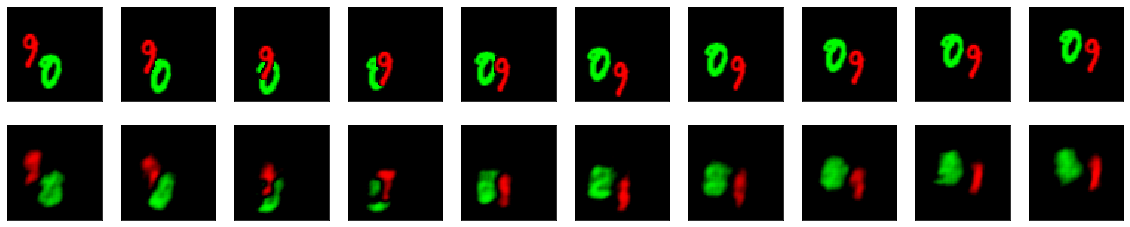

In [37]:
import matplotlib.pyplot as plt
%matplotlib inline 
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # 원본 출력
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_train_out[0,i].reshape(64, 64, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # 재구성본 출력
    ax = plt.subplot(2, n, i + n+1)
    plt.imshow(final_output[0,i].reshape(64, 64, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


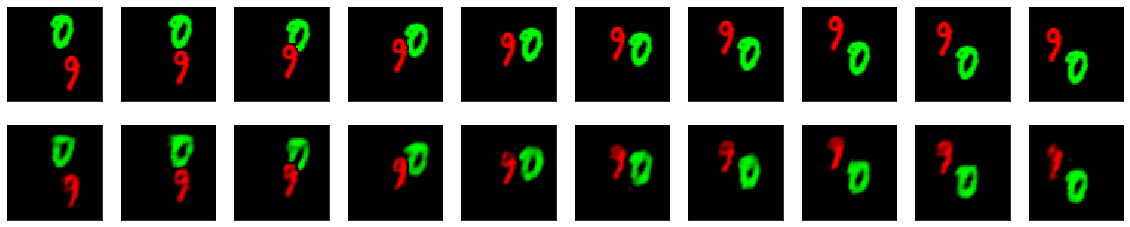

In [38]:
import matplotlib.pyplot as plt
x_train_in = x_train_in.reshape([-1,10,64,64,3])

%matplotlib inline 
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # 원본 출력
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_train_in[0,i].reshape(64, 64, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # 재구성본 출력
    ax = plt.subplot(2, n, i + n+1)
    plt.imshow(final_output_i[0,i].reshape(64, 64, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [39]:
#LSTM_model.load_weights("LSTM_new_model.h5")
inter_output = LSTM_model.predict(concate_val_in)
final_output = decoder.predict(inter_output.reshape(-1,1024)).reshape(-1,20,64,64,3)
final_output_p = final_output[:,:10,:,:,:]
final_output = final_output[:,10:,:,:,:]

In [40]:
diff = final_output.reshape(-1,64,64,3)-x_val_out.reshape(-1,64,64,3)
print(np.mean(np.abs(diff))*255)

4.698998201382128


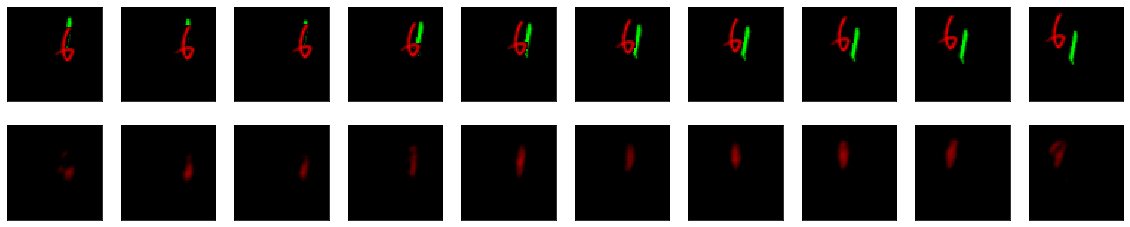

In [41]:
import matplotlib.pyplot as plt
%matplotlib inline 
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # 원본 출력
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_val_out[0,i].reshape(64, 64, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # 재구성본 출력
    ax = plt.subplot(2, n, i + n+1)
    plt.imshow(final_output[0,i].reshape(64, 64, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

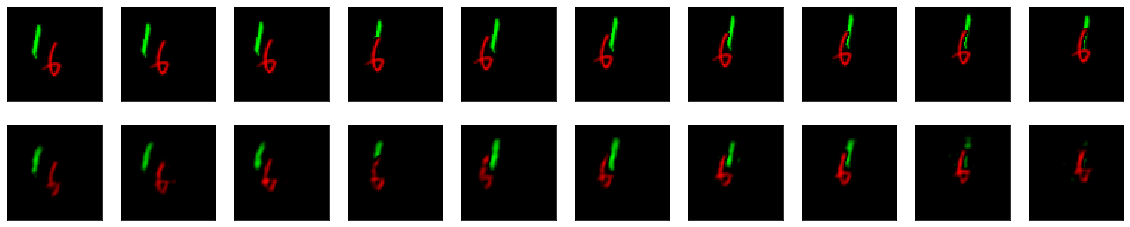

In [42]:
import matplotlib.pyplot as plt
%matplotlib inline 
x_val_in = x_val_in.reshape([-1,10,64,64,3])
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # 원본 출력
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_val_in[0,i].reshape(64, 64, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # 재구성본 출력
    ax = plt.subplot(2, n, i + n+1)
    plt.imshow(final_output_p[0,i].reshape(64, 64, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [50]:
x_test_in = data_utils.get_test_batch(0,500)
x_test_in = x_test_in.reshape([-1,64,64,3])
encoded_test_imgs_in = encoder.predict(x_test_in).reshape(-1,10,1024)
#encoded_test_imgs_out = encoder.predict(x_train_out.reshape(-1,64,64,3)).reshape(-1,10,1024)
#concate_train_out = np.concatenate((encoded_train_imgs_in, encoded_train_imgs_out), axis=1)
zero_test_vec = np.zeros_like(encoded_test_imgs_in)
concate_test_in = np.concatenate((encoded_test_imgs_in, zero_test_vec), axis=1)

In [58]:
inter_output = LSTM_model.predict(concate_test_in)
final_output = decoder.predict(inter_output.reshape(-1,1024)).reshape(-1,20,64,64,3)
final_output_i = final_output[:,:10,:,:,:]
final_output = final_output[:,10:,:,:,:]
print(final_output.shape)

(500, 10, 64, 64, 3)


In [60]:
from PIL import Image
res_path = './test_predicted'
if not os.path.exists(res_path):
        os.mkdir(res_path)
for num_seq in range(500):
    seq_path = os.path.join(res_path, "sequence%03d" % (num_seq))
    if not os.path.exists(seq_path):
        os.mkdir(seq_path)
    for i in range(10):
        name = 'frames%02d.png' % i
        file_name = os.path.join(seq_path, name)
        img_pd = final_output[num_seq,i,:,:,:]
        img_pd = np.clip(img_pd, 0, 1)
        img_pd = np.uint8(img_pd * 255)
        result = Image.fromarray(img_pd)
        result.save(file_name)